<a id="top"></a>
# Water Extent <img align="right" style="padding:10px" src="../images/odc_logo.png">
This notebook calculates the maximum water extent for a given region and time period. The water extent classification is based on the Australian Water Observations from Space (WOFS) algorithm. The results of this notebook can be useful to evaluate changes in water extent for inland water bodies (e.g. reservoirs). It is suggested that this notebook be used along with the "Cloud Statistics" notebook to evaluate the cloud conditions for any given time period as cloud contamination can impact the detection of water.  

In [1]:
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

import datacube
dc = datacube.Datacube(app = 'my_app', config = '/home/localuser/.datacube.conf')

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np  
import xarray as xr  

import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi(config = '/home/localuser/.datacube.conf')

In [2]:
# Select a Product and Platform

# product = "ls7_ledaps_ghana"
# platform = "LANDSAT_7"

# product = "ls8_lasrc_ghana"
# platform = "LANDSAT_8"

# product = "ls7_ledaps_tanzania"
# platform = "LANDSAT_7"

product = "ls8_lasrc_tanzania"
platform = "LANDSAT_8"


In [3]:
# Get Coordinates of the selected cube and print them

coordinates = api.get_full_dataset_extent(platform = platform, product = product)

latitude_extents = (min(coordinates['latitude'].values),max(coordinates['latitude'].values))
longitude_extents = (min(coordinates['longitude'].values),max(coordinates['longitude'].values))
time_extents = (min(coordinates['time'].values),max(coordinates['time'].values))

print( latitude_extents )
print( longitude_extents )
print( time_extents )

(-11.999019059879926, -0.0001356388440351325)
(28.998784571651935, 40.99806659404953)
(numpy.datetime64('2013-04-12T07:52:20.000000000'), numpy.datetime64('2018-01-01T07:21:24.000000000'))


In [4]:
# Select an analysis region (Lat-Lon) within the extents listed above. 
# Select a time period (Min-Max) within the extents listed above (Year-Month-Day)
# This region and time period will be used for the cloud assessment

# Tono Dam - Ghana
# latitude = (10.8524, 10.9457 ) 
# longitude = (-1.2034, -1.1323)

# Northern Lake Manyara, Tanzania
# Clear dates: 1/25/14, 2/13/15, 2/16/16, 9/27/16, 1/17/17, 12/3/17
# latitude =  (-3.5935, -3.3885) 
# longitude =  (35.7136, 35.9386)

# Barekese Dam - Ghana
# latitude = (6.82, 6.87)
# longitude = (-1.73, -1.68)

# Mtera Reservoir, Tanzania
# Clear
latitude = (-7.22, -6.80) 
longitude = (35.60, 36.00) 

# Time Period
time_extents = ('2016-01-01', '2016-12-31')


In [5]:
# The code below renders a map that can be used to view the region.
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude,longitude)

## Load the dataset and the required spectral bands or other parameters [&#9652;](#top)

In [6]:
landsat_dataset = dc.load(latitude = latitude,
                          longitude = longitude,
                          platform = platform,
                          time = time_extents,
                          product = product,
                          measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa']) 

In [7]:
# Displays the first few values of each data array to check the content
# Latitude and Longitude numbers = number of pixels in each dimension
# Time = number of time slices in the dataset

landsat_dataset

<xarray.Dataset>
Dimensions:    (latitude: 1549, longitude: 1476, time: 22)
Coordinates:
  * time       (time) datetime64[ns] 2016-01-08T07:44:50 ... 2016-12-25T07:45:00
  * latitude   (latitude) float64 -6.8 -6.8 -6.801 -6.801 ... -7.219 -7.22 -7.22
  * longitude  (longitude) float64 35.6 35.6 35.6 35.6 ... 36.0 36.0 36.0 36.0
Data variables:
    red        (time, latitude, longitude) int16 1048 1012 1051 ... 551 519 585
    green      (time, latitude, longitude) int16 999 984 1000 ... 564 547 573
    blue       (time, latitude, longitude) int16 579 548 571 559 ... 261 264 297
    nir        (time, latitude, longitude) int16 2719 2682 2694 ... 2864 2746
    swir1      (time, latitude, longitude) int16 2917 2909 2884 ... 1819 1984
    swir2      (time, latitude, longitude) int16 1921 1907 1870 ... 941 1059
    pixel_qa   (time, latitude, longitude) int32 322 322 322 322 ... 322 322 322
Attributes:
    crs:      EPSG:4326

### Mask out clouds and cloud shadows + water and create a median mosaic [&#9652;](#top)

In [8]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
# Land and Water Dataset = Land and Water pixels with NO Clouds and NO Cloud Shadows
cloud_mask = landsat_qa_clean_mask(landsat_dataset, platform=platform)
land_and_water_dataset = landsat_dataset.where(cloud_mask)

In [9]:
from utils.data_cube_utilities.dc_mosaic import create_median_mosaic
# Create a median mosaic for viewing only
land_and_water_composite = create_median_mosaic(land_and_water_dataset, cloud_mask)

In [10]:
from utils.data_cube_utilities.dc_water_classifier import wofs_classify
# WOFS water classification 
water_classification = wofs_classify(land_and_water_dataset)
# Check for the maximum water extent over the time period
water_max_extents = water_classification.max('time')

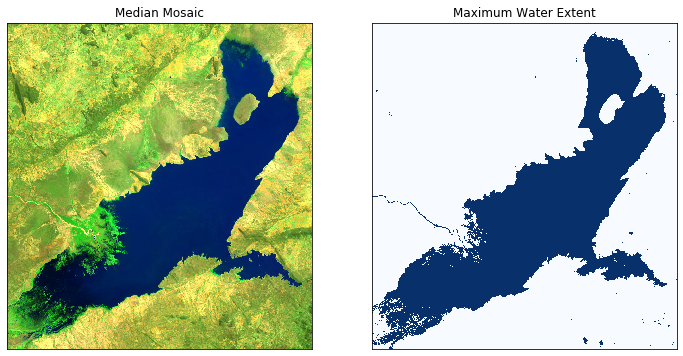

In [11]:
from utils.data_cube_utilities.dc_rgb import rgb
fig, ax = plt.subplots(1, 2, figsize=(12,6))

composite_rgb = land_and_water_composite[['swir2', 'nir', 'green']].to_array()

# Use the middle values of the data (2% to 98%) to brighten the image
rgb_vmin = composite_rgb.quantile(0.02).values
rgb_vmax = composite_rgb.quantile(0.98).values

# Plot the resulting 2 products ... Baseline RGB, Water Extent
composite_rgb.plot.imshow(ax=ax[0], vmin=rgb_vmin, vmax=rgb_vmax)
water_max_extents.wofs.plot.imshow(ax=ax[1], cmap='Blues', add_colorbar=False)

# Titles
ax[0].set_title('Median Mosaic'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('Maximum Water Extent'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)

plt.show()

### Water Pixel Counts [&#9652;](#top)

In [12]:
# WOFS values = 0.0 (no water) or 1.0 (water)
# The threshold uses a range of 0.99 to 1.01 to identify water (WOFS=1.0)

wofs_minimum_threshold = 0.99
wofs_maximum_threshold = 1.01

In [13]:
def threshold_count(da, min_threshold, max_threshold, mask = None):
    def count_not_nans(arr):
        return np.count_nonzero(~np.isnan(arr))
    
    in_threshold = np.logical_and( da.values > min_threshold, da.values < max_threshold)
    
    total_non_cloudy = count_not_nans(da.values) if mask is None else np.sum(mask) 
    
    return dict(total = np.size(da.values),
                total_non_cloudy = total_non_cloudy,
                inside = np.nansum(in_threshold),
                outside = total_non_cloudy - np.nansum(in_threshold)
               )    

In [14]:
# COUNT = number of pixels in each category
# INSIDE = Number of water pixels 
threshold_count(water_max_extents.wofs,wofs_minimum_threshold,wofs_maximum_threshold)

{'total': 2286324,
 'total_non_cloudy': 2286324,
 'inside': 663281,
 'outside': 1623043}

## GeoTIFF Output Products [&#9652;](#top)

In [15]:
# from utils.data_cube_utilities.dc_utilities import write_geotiff_from_xr

# Remove the comment to create a GeoTIFF output product
# Change the name of the output file, or it will be overwritten for each run 
# Change the desired bands at the end of the function

# write_geotiff_from_xr("geotiffs/water_extent_sample.tif", water_max_extents, bands=['wofs'])

In [16]:
# !ls -lah geotiffs/*.tif